## 1. Importing the libraries

In [1]:
from src.dataset.create_dataset import *
from src.model.classifiers import GaussianNBModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import time
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark import StorageLevel
from pyspark.sql.types import *

sns.set_style('white')

## 2. Initialize Spark Session

In [2]:
appName = 'Yellow-Taxi-Analysis'
token = os.environ['GOOGLE_APPLICATION_CREDENTIALS']
BUCKET_NAME = 'yellow_taxi_vineet'

spark = SparkSession.builder.master('local[*]').appName(appName).config("spark.jars",
                                                                        "/usr/local/Cellar/apache-spark/3.3.0/libexec/jars/postgresql-42.4.1.jar").getOrCreate()

spark

22/08/17 01:22:59 WARN Utils: Your hostname, Vineets-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.150 instead (on interface en0)
22/08/17 01:22:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/08/17 01:22:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## 3. Execute Postgresql queries and save to desired format

After loading the data into any format, we can run analysis against.

#### Using JBDC

In [3]:
url = "jdbc:postgresql://localhost:5432/new_york_trips"
driver = "org.postgresql.Driver"

properties = {
    "url"   : url,
    "driver": driver
}

#### Using psycopg2

In [4]:
import psycopg2

conn = psycopg2.connect(
    database="new_york_trips", user='vineetverma', password='*******', host='localhost', port='5432'
)
cursor = conn.cursor()

## 4. Analysis

### Number of entries in the dataset

Just to get a sense of the size of the dataset, we can count the number of rows in the dataset.

In [37]:
query = "(SELECT COUNT(*) FROM trips) AS t"
df = spark.read.jdbc(url=url, table=query, properties=properties, chunksize=1000)
df.show()

+---------+
|    count|
+---------+
|893296912|
+---------+

--- 594.711728811264 seconds ---


### How does taxi usage change over a month

This is a good time to look at how the taxi usage changes over a month. We can use the following query to get the number of trips per day of all the months.

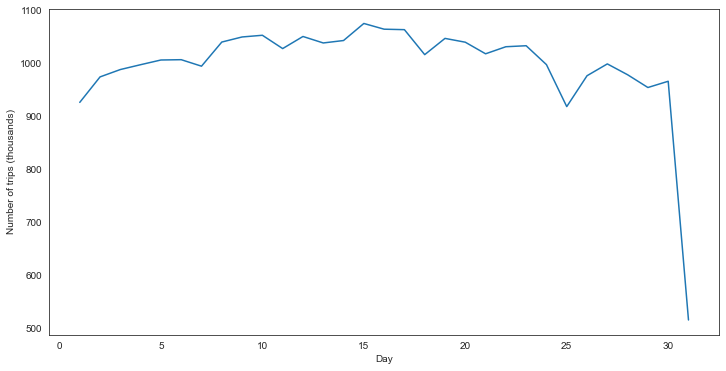

In [7]:
viz = spark.sql("""
SELECT
    day(DATE_TRUNC('DD', TO_DATE(tpep_pickup_datetime))) AS day,
    ROUND(COUNT(1)/1000, 2) AS trip_count
FROM
    new_york_trips.public.trips
GROUP BY
    day
""").toPandas()

fig = plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='day', y='trip_count', data=viz, color='#1f77b4')
ax.set_xlabel('Day')
ax.set_ylabel('Number of trips (thousands)')
plt.show()

We can see that taxi usage is consistent throughout each day of the month. We can also see that the number of trips falls off at the end of the month.

### Most popular months in year 2021 for taxi trips

Here we can see the trend of taxi usage over the year 2021.

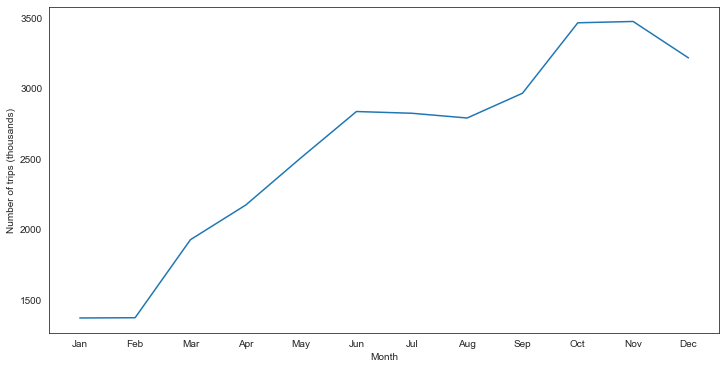

In [30]:
viz = spark.sql("""
SELECT
    month(DATE_TRUNC('MM', TO_DATE(tpep_pickup_datetime))) AS month,
    ROUND(COUNT(1)/1000, 2) AS trip_count
FROM
    new_york_trips.public.trips
GROUP BY
    month
""").toPandas()

fig = plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='month', y='trip_count', data=viz, color='#1f77b4')
ax.set_xlabel('Month')
ax.set_ylabel('Number of trips (thousands)')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
              ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

The number of trips consistently increases throughout the year. The number of trips is highest in the month of October and November. The number of trips is lowest in the month of January and February.

### How trips are distributed by day of the week

Which day of the week is the most popular for taxi trips? We can use the following query to get the number of trips per day of the week.

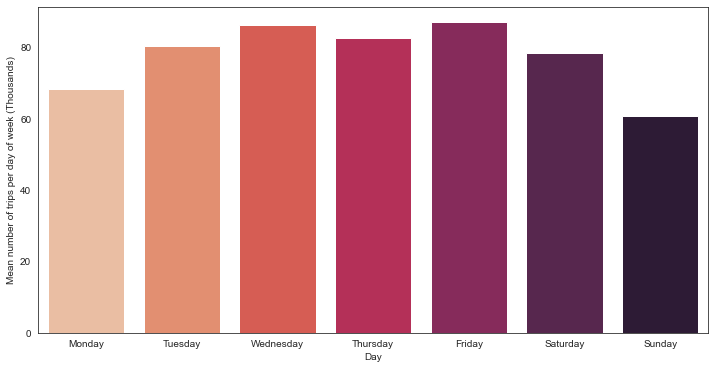

In [52]:
viz = spark.sql("""
SELECT
    TO_DATE(tpep_pickup_datetime) AS pickup_time,
    DATE_FORMAT(tpep_pickup_datetime, 'EEEE') AS day,
    ROUND(COUNT(*)/1000, 2) AS trip_count
FROM
    new_york_trips.public.trips
GROUP BY
    pickup_time,
    day
""").toPandas()

mean_trips_week_day = viz.groupby('day').agg({'trip_count': 'mean'}).reset_index()
mean_trips_week_day = mean_trips_week_day.set_index('day').reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index()

fig = plt.figure(figsize=(12, 6))
ax = sns.barplot(x='day', y='trip_count', data=mean_trips_week_day, palette='rocket_r')
ax.set_xlabel('Day')
ax.set_ylabel('Mean number of trips per day of week (Thousands)')
plt.show()

The most popular day of the week for taxi trips is Friday. The number of trips is highest on Friday and lowest on Sunday.

### Looking at the distribution of trips, distance and fare amount by hour of the day

In [46]:
viz = spark.sql("""
SELECT
    TO_DATE(tpep_pickup_datetime) AS pickup_time,
    DATE_FORMAT(tpep_pickup_datetime, 'EEEE') AS day,
    HOUR(tpep_pickup_datetime) AS hour,
    ROUND(COUNT(*)/1000, 2) AS trip_count,
    MEAN(trip_distance) AS mean_distance,
    ROUND(MEAN(fare_amount)) AS fare_amount,
    ROUND(MEAN((unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime))/60), 2) AS mean_duration,
    ROUND(MEAN(trip_distance/((unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime))/3600)),2) AS mean_speed
FROM
    new_york_trips.public.trips
GROUP BY
    day, hour, pickup_time
""").toPandas()

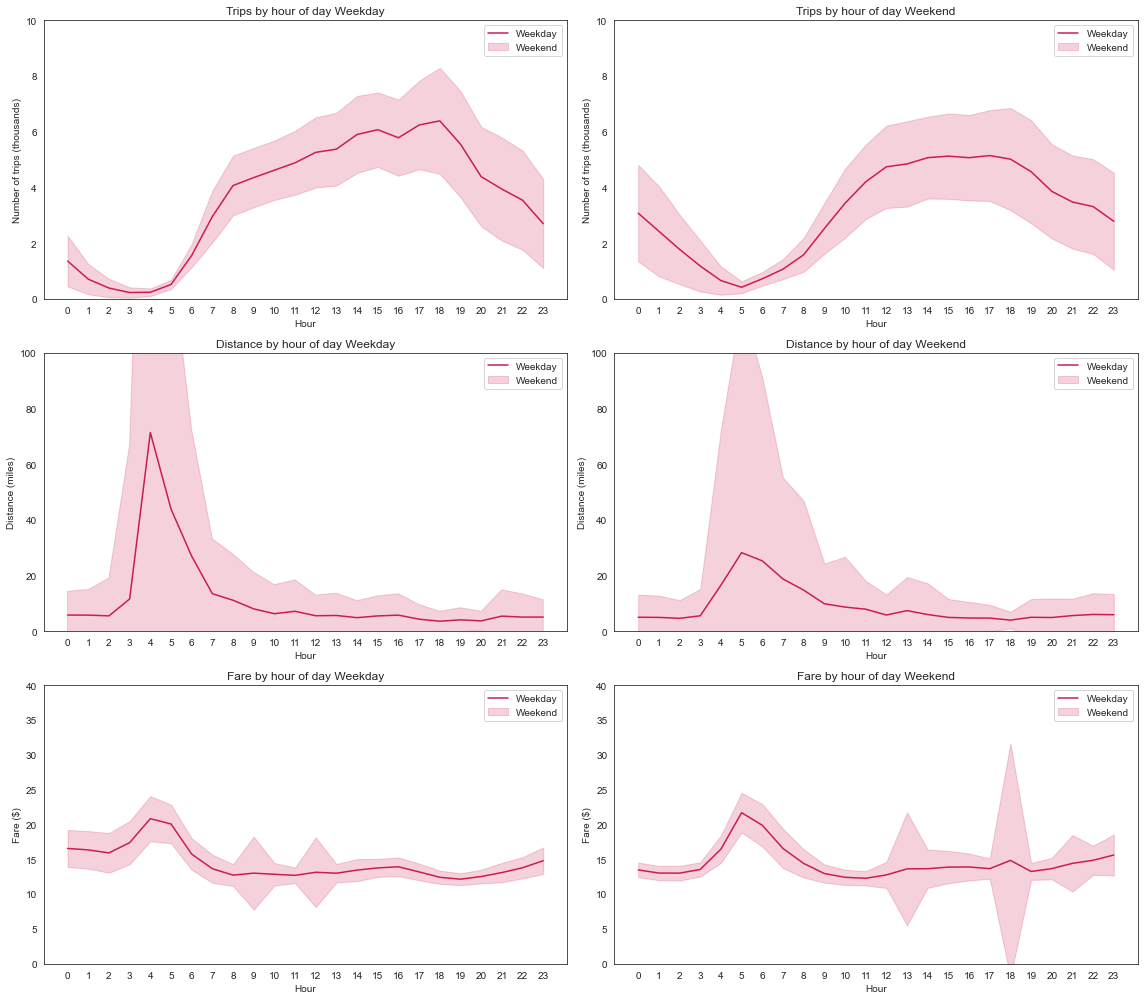

In [54]:
viz['weekend'] = viz['day'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
y = ['trip_count', 'mean_distance', 'fare_amount']
title = ['Trips by hour of day', 'Distance by hour of day', 'Fare by hour of day']
ylabel = ['Number of trips (thousands)', 'Distance (miles)', 'Fare ($)']
ylim = [[0, 10], [0, 100], [0, 40]]

fig, ax = plt.subplots(3, 2, figsize=(16, 14))
for i in range(len(y)):
    for j in range(0, 2):
        sns.lineplot(x='hour', ci='sd', y=y[i], data=viz[viz['weekend'] == j], ax=ax[i, j], hue='weekend',
                     palette='rocket')
        ax[i, j].set_xlabel('Hour')
        ax[i, j].legend(['Weekday', 'Weekend'])
        ax[i, j].set(xticks=np.arange(0, 24, 1))
        ax[i, j].set_ylim(ylim[i])
        ax[i, j].set_ylabel(ylabel[i])
        ax[i, j].set_title(f'{title[i]} Weekend' if j == 1 else f'{title[i]} Weekday')
plt.tight_layout()
plt.show()

## 5. Pipeline

### Preprocess (load data -> clean data -> save preprocessed data to cloud)

In [ ]:
!python../ main / preprocess.py

 ### Generate the features (generate features -> save the new dataframe with features to cloud)

In [ ]:
!python../ main / feature_engineering.py

### train the model (train the model -> save the model to cloud)

In [ ]:
!python../ main / train_model.py

### Demo for model training

In [ ]:
# load final dataframes from the cloud 
train_df = get_output_data('data/features/train/2014-2022')
test_df = get_output_data('data/features/test/2014-2022')

In [ ]:
!python ../main/train_model.py

In [3]:
train_df.head(5)

,trip_duration,trip_speed,trip_tolls,pickup_weekday,pickup_hour,pickup_minute,work_hours,meter_eng,meter_dis,total_tip,total_fare,tip_percentage,big_tip,tpep_pickup_datetime,tpep_dropoff_datetime
0,85183.0,0.000184,0.0,1,0,44,False,138,38,28.61,141.0,20.290780,False,2022-01-04 00:44:43,2022-01-05 00:24:26
1,5477.0,0.000026,0.0,1,22,43,False,132,161,12.85,63.0,20.396825,False,2022-01-04 22:43:04,2022-01-05 00:14:21
2,83457.0,0.000012,0.0,1,3,20,False,48,264,0.00,5.5,0.000000,False,2022-01-04 03:20:48,2022-01-05 02:31:45
3,85516.0,0.000052,0.0,1,3,13,False,48,41,0.00,15.0,0.000000,False,2022-01-04 03:13:33,2022-01-05 02:58:49
4,67491.0,0.000029,0.0,1,5,15,False,170,140,0.00,8.0,0.000000,False,2022-01-04 05:15:09,2022-01-05 00:00:00


In [4]:
## Choose the features and the label
label = 'big_tip'
features = list(train_df.columns.drop([label, 'tpep_pickup_datetime', 'tpep_dropoff_datetime']))

In [5]:
## Initialize the model
model = GaussianNBModel(features=features, label=label)

In [6]:
## Split the data into train and test
x_train, y_train = model.preprocess(train_df)
x_test, y_test = model.preprocess(test_df)

In [7]:
## Fit the model
history = model.fit(x_train, y_train)

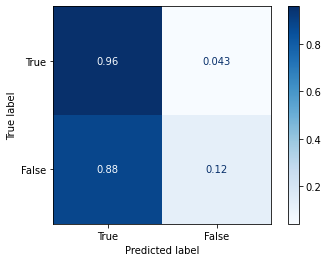

In [8]:
## Plot the confusion matrix (normalized
model.plot_confusion_matrix(x_test, y_test, normalize='true')

In [ ]:
## 10-Fold Cross-validation on the testing data
model.cross_validate(x_test, y_test)